# Magnetic potential for a Ring of Current

# Source:
http://nptel.ac.in/courses/115101005/downloads/lectures-doc/Lecture-25.pdf and Bhooshan https://www.amazon.com/Fundamentals-Engineering-Electromagnetics-Sunil-Bhooshan/dp/0198077947/ref=sr_1_4?ie=UTF8&qid=1519255078&sr=8-4&keywords=bhooshan page 268 ex 8.17

Also thanks to Stephan Hoyer @shoyer for help with https://github.com/pydata/xarray/issues/1773

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Magnetic-potential-for-a-Ring-of-Current" data-toc-modified-id="Magnetic-potential-for-a-Ring-of-Current-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Magnetic potential for a Ring of Current</a></span></li><li><span><a href="#Source:" data-toc-modified-id="Source:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Source:</a></span></li><li><span><a href="#Sympy-Aspect" data-toc-modified-id="Sympy-Aspect-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Sympy Aspect</a></span></li><li><span><a href="#Generate-the-xarray-dataset-for-the-data" data-toc-modified-id="Generate-the-xarray-dataset-for-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate the xarray dataset for the data</a></span></li><li><span><a href="#Transfer-the-xarray-to-yt" data-toc-modified-id="Transfer-the-xarray-to-yt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transfer the xarray to yt</a></span></li><li><span><a href="#Plotting-the-Magnetic-Potential" data-toc-modified-id="Plotting-the-Magnetic-Potential-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plotting the Magnetic Potential</a></span></li><li><span><a href="#Plotting-the-Bx-and-Bz-fields-(attempting-superposition-from-within-yt)" data-toc-modified-id="Plotting-the-Bx-and-Bz-fields-(attempting-superposition-from-within-yt)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting the Bx and Bz fields (attempting superposition from within yt)</a></span></li></ul></div>

In [1]:
from sympy import *
init_printing()

import numpy as np
import xarray as xr
import itertools as Iter

import yt
yt.toggle_interactivity()

from scipy import constants as consts

import matplotlib.pyplot as plt
%matplotlib notebook

Using matplotlib backend: Qt5Agg


# Sympy Aspect 

In [2]:
I, x, y, z, r, rho0, theta=symbols('I, x, y, z, r, rho_0, theta')

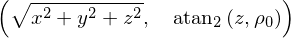

In [3]:
rdef=sqrt(x**2+y**2+z**2)
thetaDef=atan2(z, rho0)
rdef, thetaDef

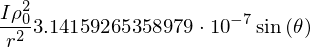

In [4]:
Ay=(consts.mu_0*rho0**2*I/4)*sin(theta)/r**2
Ay

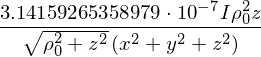

In [5]:
Ay=simplify(Ay.subs({theta:thetaDef, r: rdef})); Ay

In [6]:
sups={rho0:.5, I:1} #current loop with radidis .5m with 1A
sups

In [7]:
AyN=lambdify((x, y, z), Ay.subs(sups), dummify=False)
AyN(1,1,1)

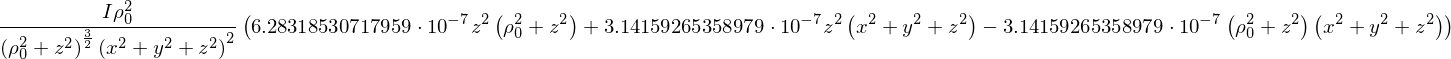

In [8]:
Bx=simplify(-Derivative(Ay, z).doit()); Bx

In [9]:
BxN=lambdify((x, y, z), Bx.subs(sups), dummify=False)
BxN(1,1,1)

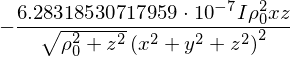

In [10]:
Bz=simplify(Derivative(Ay, x).doit()); Bz

In [11]:
BzN=lambdify((x, y, z), Bz.subs(sups), dummify=False)
BzN(1,1,1)

# Generate the xarray dataset for the data

In [12]:
DomainSpaceSize = 6 # using cartesian 3D
SpaceDensity = [10] # 100 divisions in space 5 in time


In [13]:
x_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity[0])
y_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity[0])
z_coord = np.linspace(-DomainSpaceSize, +DomainSpaceSize, SpaceDensity[0])

In [14]:
CoorEnterFunc = lambda x, y, z: 1+0*x+0*y+0*z

dx=xr.DataArray(x_coord, dims='x')
dy=xr.DataArray(y_coord, dims='y')
dz=xr.DataArray(z_coord, dims='z')

In [15]:
SimDataSet = xr.Dataset({'Ay':(['x', 'y', 'z'], AyN(*np.meshgrid(x_coord, y_coord, z_coord)))},
                  coords={'x':x_coord, 'y':y_coord, 'z':z_coord})
SimDataSet.attrs['units']={'Ay':'V/s/m'}
SimDataSet

<xarray.Dataset>
Dimensions:  (x: 10, y: 10, z: 10)
Coordinates:
  * x        (x) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * y        (y) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * z        (z) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
Data variables:
    Ay       (x, y, z) float64 -7.247e-10 -8.327e-10 -9.345e-10 -1.003e-09 ...
Attributes:
    units:    {'Ay': 'V/s/m'}

In [16]:
SimDataSet['Bx']=(['x', 'y', 'z',],BxN(*np.meshgrid(x_coord, y_coord, z_coord)))
SimDataSet.attrs['units']['Bx']='T'
SimDataSet

<xarray.Dataset>
Dimensions:  (x: 10, y: 10, z: 10)
Coordinates:
  * x        (x) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * y        (y) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * z        (z) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
Data variables:
    Ay       (x, y, z) float64 -7.247e-10 -8.327e-10 -9.345e-10 -1.003e-09 ...
    Bx       (x, y, z) float64 7.969e-11 8.085e-11 6.879e-11 2.328e-11 ...
Attributes:
    units:    {'Ay': 'V/s/m', 'Bx': 'T'}

In [17]:
SimDataSet['Bz']=(['x', 'y', 'z',],BzN(*np.meshgrid(x_coord, y_coord, z_coord)))
SimDataSet.attrs['units']['Bz']='T'
SimDataSet

<xarray.Dataset>
Dimensions:  (x: 10, y: 10, z: 10)
Coordinates:
  * x        (x) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * y        (y) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
  * z        (z) float64 -6.0 -4.667 -3.333 -2.0 -0.6667 0.6667 2.0 3.333 ...
Data variables:
    Ay       (x, y, z) float64 -7.247e-10 -8.327e-10 -9.345e-10 -1.003e-09 ...
    Bx       (x, y, z) float64 7.969e-11 8.085e-11 6.879e-11 2.328e-11 ...
    Bz       (x, y, z) float64 -8.052e-11 -1.066e-10 -1.349e-10 -1.583e-10 ...
Attributes:
    units:    {'Ay': 'V/s/m', 'Bx': 'T', 'Bz': 'T'}

# Transfer the xarray to yt

In [18]:
bbox=[]
for i in ['x', 'y', 'z']:
    bbox.append([float(SimDataSet.coords[i].min()), float(SimDataSet.coords[i].max())])
bbox=np.array(bbox)
bbox

array([[-6.,  6.],
       [-6.,  6.],
       [-6.,  6.]])

In [19]:
YTDataObj= dict(MagPoty = (np.array(SimDataSet['Ay']), 'g/m**3'),
                MagFieldx = (np.array(SimDataSet['Bx']), 'g/m**3'),
                MagFieldz = (np.array(SimDataSet['Bz']), 'g/m**3')
               )
#would not except unit in SimDataSet.attrs['units']['ChargeDen'] had to fake with
#'g/m**3'

In [20]:
YTDataObj = yt.load_uniform_grid(YTDataObj, tuple(dict(SimDataSet.dims).values()), length_unit="m", bbox=bbox, nprocs=64)


yt : [INFO     ] 2018-02-21 16:29:44,209 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-02-21 16:29:44,211 Parameters: domain_dimensions         = [10 10 10]
yt : [INFO     ] 2018-02-21 16:29:44,212 Parameters: domain_left_edge          = [-6. -6. -6.]
yt : [INFO     ] 2018-02-21 16:29:44,212 Parameters: domain_right_edge         = [ 6.  6.  6.]
yt : [INFO     ] 2018-02-21 16:29:44,214 Parameters: cosmological_simulation   = 0.0


Trying to do transfer function but giving up

In [21]:
tf = yt.ColorTransferFunction((SimDataSet['Ay'].min(), SimDataSet['Ay'].max()), grey_opacity=False)
tf.map_to_colormap(SimDataSet['Ay'].min(), SimDataSet['Ay'].max(), scale=15.0, colormap='algae')


# Plotting the Magnetic Potential 

In [22]:
MagPotyScene = yt.create_scene(YTDataObj, 'MagPoty')
source2 = MagPotyScene[0]
MagPotyScene.camera.set_width(MagPotyScene.quan(7, 'm'))


yt : [INFO     ] 2018-02-21 16:29:45,197 Rendering scene (Can take a while).
yt : [INFO     ] 2018-02-21 16:29:45,200 Creating volume
/home/iridium/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-02-21 16:29:45,315 Creating transfer function
yt : [INFO     ] 2018-02-21 16:29:45,316 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.


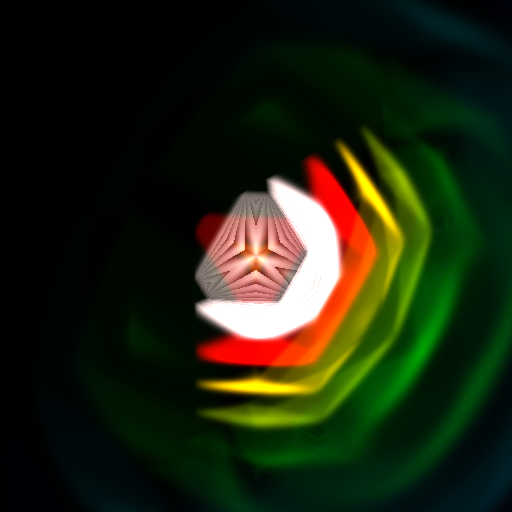

In [23]:
MagPotyScene.show(sigma_clip=3)
# the transfer function should have a defualt to the max min of the data cube
#being renderd

# Plotting the Bx and Bz fields (attempting superposition from within yt)

In [24]:
from yt.visualization.volume_rendering.api import Scene, VolumeSource


In [25]:
sc = Scene()
cam = sc.add_camera(YTDataObj, lens_type='perspective')
cam.resolution = [400, 400]
cam.position = YTDataObj.arr([9, 9, 9], 'm')
cam.switch_orientation()

yt : [INFO     ] 2018-02-21 16:29:49,025 Rendering scene (Can take a while).
yt : [INFO     ] 2018-02-21 16:29:49,027 Creating volume
/home/iridium/anaconda3/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-02-21 16:29:49,692 Creating transfer function
yt : [INFO     ] 2018-02-21 16:29:49,693 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.


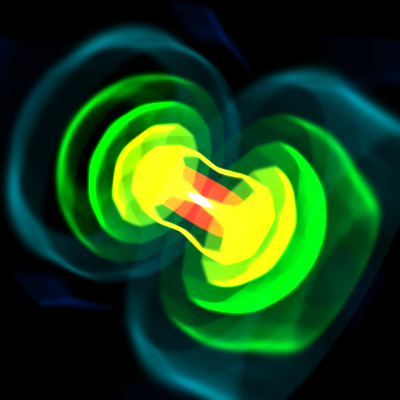

In [26]:
BFx = VolumeSource(YTDataObj, field='MagFieldx')
BFx.use_ghost_zones = True
sc.add_source(BFx)
sc.show( sigma_clip=1)



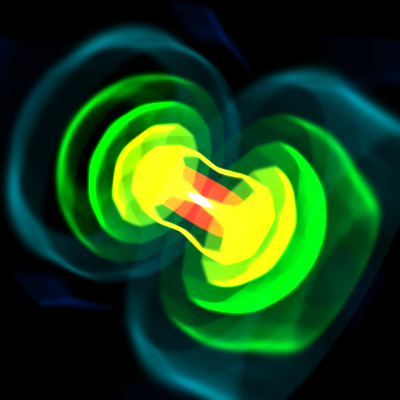

In [27]:
# add rendering of x-velocity field
BFz = VolumeSource(YTDataObj, field='MagFieldz')
BFz.use_ghost_zones = True
sc.add_source(BFz)
sc.show( sigma_clip=1)


Not sure if this consulted the Bx and Bz fields into one image